In [4]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns, matplotlib.pyplot as plt
import random 
import warnings

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch 
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer

warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

In [5]:
# Load the datasets
train_df = pd.read_excel("../Datasets/Train.xlsx")
test_df  = pd.read_excel("../Datasets/Test.xlsx")

print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)
print(train_df["Expected Operation by Developer"].value_counts())

Train shape: (931, 2)
Test  shape: (234, 2)
Expected Operation by Developer
insert     322
delete     309
replace    300
Name: count, dtype: int64


In [6]:
# Train-validation split
X_full = train_df["Review Comment"]
y_full = train_df["Expected Operation by Developer"]

X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.10, random_state=SEED, stratify=y_full
)

print("Train size:", len(X_train), "   Val size:", len(X_val))

Train size: 837    Val size: 94


In [7]:
device   = "cuda" if torch.cuda.is_available() else "cpu"
embedder = SentenceTransformer("all-MiniLM-L6-v2", device=device)

def embed(texts):
    return embedder.encode(
        texts.tolist(), show_progress_bar=True, batch_size=64, device=device
    )

Xtr_emb = embed(X_train)
Xval_emb = embed(X_val)

Batches: 100%|██████████| 2/2 [00:00<00:00, 34.39it/s]


In [8]:
param_grid = {
    "C": [0.1, 0.5, 1, 2, 5, 10]
}

base_svc = LinearSVC(
    C=1.0,
    loss="hinge",          # or "squared_hinge"
    random_state=SEED
)

search = GridSearchCV(
    base_svc,
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring="accuracy",
    verbose=1
)
search.fit(Xtr_emb, y_train)

print("Best CV-acc:", search.best_score_)
print("Best C:", search.best_params_["C"])
best_svc = search.best_estimator_


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true

Best CV-acc: 0.535186769318506
Best C: 0.5


In [9]:
X_full_emb = embed(X_full)           # reuse if already computed

final_model = best_svc if "best_svc" in globals() else base_svc
final_model.fit(X_full_emb, y_full)


Batches: 100%|██████████| 15/15 [00:00<00:00, 58.83it/s]


LinearSVC(C=0.5, loss='hinge', random_state=42)

Batches: 100%|██████████| 4/4 [00:00<00:00, 36.63it/s]


Test accuracy: 0.5897

              precision    recall  f1-score   support

      delete       0.63      0.60      0.61        78
      insert       0.59      0.54      0.56        81
     replace       0.56      0.63      0.59        75

    accuracy                           0.59       234
   macro avg       0.59      0.59      0.59       234
weighted avg       0.59      0.59      0.59       234



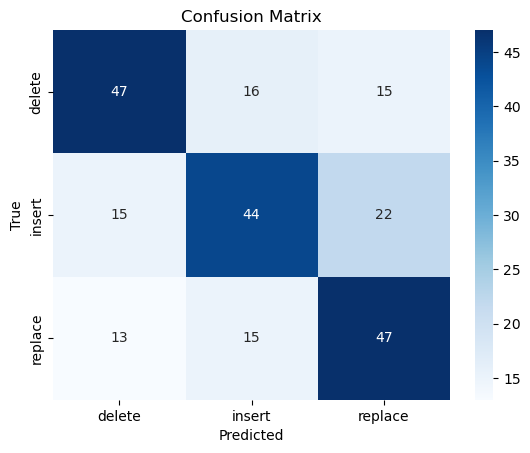

In [11]:
X_test  = test_df["Review Comment"].astype(str)
y_test  = test_df["Expected Operation by Developer"]
Xtest_emb = embed(X_test)            # reuse if already computed

y_pred = final_model.predict(Xtest_emb)
acc    = accuracy_score(y_test, y_pred)
print(f"\nTest accuracy: {acc:.4f}\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_full))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_full),
            yticklabels=np.unique(y_full))
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()


In [12]:
coef = final_model.coef_
for cls, vec in zip(final_model.classes_, coef):
    top10 = np.argsort(vec)[-10:][::-1]
    print(f"\nClass '{cls}' – strongest dims:", top10)



Class 'delete' – strongest dims: [376 136 317 206 261 299  37 180 204  44]

Class 'insert' – strongest dims: [286  46 131  87 115  81 298  86   5 343]

Class 'replace' – strongest dims: [149  70 201  39 209 233 213 323  66 368]
